In [1]:
from openai import OpenAI
import json
import re
import numpy as np
import pandas as pd
import random
from sklearn.model_selection import train_test_split
from IPython.display import display, Markdown
from copy import deepcopy
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm import tqdm
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
client = OpenAI()

# Step 1: Explore the data

Explore the data in full

## 1. Metdata csv file

In [4]:
df_call_metadata = pd.read_csv('/Users/sohammistri/Documents/Prodigal-Take-Home/sentiment-take-home/call_metadata.csv')
print(df_call_metadata.head())
print(df_call_metadata.info())

                                    _id     duration            disposition  \
0  1558137f-4ab5-409e-8159-109c2e9358d5  3927.771375    No Pay - Bankruptcy   
1  05c54daf-9bca-4bd7-b833-b3ba8c1e06e0   146.520000  No Pay - Cant pay now   
2  84fb4fec-b36f-43bc-a4ef-a27ba322c146   749.635875       No Pay - Dispute   
3  2133927a-0d11-4d54-98d6-cd21c71417f0   448.104375       No Pay - Dispute   
4  048518c6-c17c-4524-8ff3-6a0b2735863c   108.432000       No Pay - Dispute   

       type  
0  negative  
1  negative  
2  negative  
3  negative  
4  negative  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   _id          2000 non-null   object 
 1   duration     2000 non-null   float64
 2   disposition  2000 non-null   object 
 3   type         2000 non-null   object 
dtypes: float64(1), object(3)
memory usage: 62.6+ KB
None


In [5]:
print(df_call_metadata['type'].value_counts())

type
negative    1000
positive    1000
Name: count, dtype: int64


In [6]:
print(df_call_metadata['disposition'].value_counts())

disposition
No Pay - Dispute                    439
Promise - Payment in full           313
No Pay - Not right now              296
Promise - Payment plan              256
No Pay - Cant pay now               182
Promise - Settlement in full        163
Promise - One time payment          104
Payment Plan Modification           101
Promise - Settlement in payments     63
No Pay - Can't pay now               42
No Pay - Bankruptcy                  30
No Pay - Cancel payment plan         11
Name: count, dtype: int64


In [7]:
df_call_metadata['disposition'] = df_call_metadata['disposition'].replace("No Pay - Can't pay now", "No Pay - Cant pay now")

In [8]:
disposition_type_counts = df_call_metadata.groupby('disposition')['type'].value_counts().unstack(fill_value=0)
print(disposition_type_counts)

type                              negative  positive
disposition                                         
No Pay - Bankruptcy                     30         0
No Pay - Cancel payment plan            11         0
No Pay - Cant pay now                  224         0
No Pay - Dispute                       439         0
No Pay - Not right now                 296         0
Payment Plan Modification                0       101
Promise - One time payment               0       104
Promise - Payment in full                0       313
Promise - Payment plan                   0       256
Promise - Settlement in full             0       163
Promise - Settlement in payments         0        63


In [9]:
positive_dispositions = set(disposition_type_counts[disposition_type_counts['positive'] > 0].index.tolist())
negative_dispositions = set(disposition_type_counts[disposition_type_counts['negative'] > 0].index.tolist())

print("Positive disposition types:", positive_dispositions)
print("Negative disposition types:", negative_dispositions)

Positive disposition types: {'Payment Plan Modification', 'Promise - Settlement in payments', 'Promise - Payment plan', 'Promise - One time payment', 'Promise - Settlement in full', 'Promise - Payment in full'}
Negative disposition types: {'No Pay - Dispute', 'No Pay - Not right now', 'No Pay - Cancel payment plan', 'No Pay - Cant pay now', 'No Pay - Bankruptcy'}


In [10]:
len(positive_dispositions), len(negative_dispositions)

(6, 5)

### Split dataset into train-val-test

We do 80-10-10 train-val-test split, ensuring there is no class imbalance in either split

In [11]:
from sklearn.model_selection import train_test_split

# Separate positive and negative samples
df_positive = df_call_metadata[df_call_metadata['type'] == 'positive']
df_negative = df_call_metadata[df_call_metadata['type'] == 'negative']

# Calculate split sizes
train_size = 0.8
val_size = 0.1
test_size = 0.1

def split_df(df, train_size, val_size, test_size):
    df_train, df_temp = train_test_split(df, train_size=train_size, random_state=42, shuffle=True)
    relative_val_size = val_size / (val_size + test_size)
    df_val, df_test = train_test_split(df_temp, train_size=relative_val_size, random_state=42, shuffle=True)
    return df_train, df_val, df_test

# Split positive and negative samples
pos_train, pos_val, pos_test = split_df(df_positive, train_size, val_size, test_size)
neg_train, neg_val, neg_test = split_df(df_negative, train_size, val_size, test_size)

# Concatenate to get final splits with equal positive and negative samples
train_df = pd.concat([pos_train, neg_train]).sample(frac=1, random_state=42).reset_index(drop=True)
val_df = pd.concat([pos_val, neg_val]).sample(frac=1, random_state=42).reset_index(drop=True)
test_df = pd.concat([pos_test, neg_test]).sample(frac=1, random_state=42).reset_index(drop=True)

print(f"Train shape: {train_df.shape}, Positive: {(train_df['type'] == 'positive').sum()}, Negative: {(train_df['type'] == 'negative').sum()}")
print(f"Val shape: {val_df.shape}, Positive: {(val_df['type'] == 'positive').sum()}, Negative: {(val_df['type'] == 'negative').sum()}")
print(f"Test shape: {test_df.shape}, Positive: {(test_df['type'] == 'positive').sum()}, Negative: {(test_df['type'] == 'negative').sum()}")

Train shape: (1600, 4), Positive: 800, Negative: 800
Val shape: (200, 4), Positive: 100, Negative: 100
Test shape: (200, 4), Positive: 100, Negative: 100


In [12]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600 entries, 0 to 1599
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   _id          1600 non-null   object 
 1   duration     1600 non-null   float64
 2   disposition  1600 non-null   object 
 3   type         1600 non-null   object 
dtypes: float64(1), object(3)
memory usage: 50.1+ KB


In [13]:
train_df.to_csv('/Users/sohammistri/Documents/Prodigal-Take-Home/sentiment-take-home/train_df.csv', index=False)
val_df.to_csv('/Users/sohammistri/Documents/Prodigal-Take-Home/sentiment-take-home/val_df.csv', index=False)
test_df.to_csv('/Users/sohammistri/Documents/Prodigal-Take-Home/sentiment-take-home/test_df.csv', index=False)

## 2. Conversations

In [14]:
import os

conversation_folder = '/Users/sohammistri/Documents/Prodigal-Take-Home/sentiment-take-home/conversations'
txt_files = [f for f in os.listdir(conversation_folder) if f.endswith('.txt')]
print(f"Number of text files: {len(txt_files)}")

Number of text files: 2000


In [15]:
# Remove '.txt' extension from txt_files to get basenames
txt_basenames = set([os.path.splitext(f)[0] for f in txt_files])

# Get set of _id values from df_call_metadata
df_ids = set(df_call_metadata['_id'])

assert txt_basenames == df_ids

In [16]:
assert df_call_metadata['_id'].is_unique, "Not all _id values are unique in df_call_metadata"

In [17]:
random_txt = random.choice(txt_files)
txt_path = os.path.join(conversation_folder, random_txt)
with open(txt_path, 'r') as f:
    content = f.read()

display(Markdown(f"### {random_txt}\n\n{content}"))

### dbea8497-edcb-453f-ae23-47ec7a529c5c.txt

agent 00:01-00:14
thank you for calling cherokee my name is tanisha agent id one three zero one this call is being recorded and may be monitored for quality assurance purposes continuing you you're providing consent may i have your account number beginning with * *

borrower 00:16-00:31
oh wait a minute i don't know that can me state do i have a account number how did that come over with agency XYZ i think they * * was the text message i don't know i mean i'm trying to find it back go back to it

agent 00:33-00:35
okay did you get a text message or onemain

borrower 00:33-00:34
oh cool

borrower 00:36-00:59
text messages but i got and he say you said but then when i clicked it it saying you gave me the balance and all this stuff about something i wasn't really it me with then when i went back and clicked on it payment plan of details it this conns find this * yes and we cannot find your line * * * * * * * * * * * * *

agent 00:37-00:38
amex message

agent 00:50-00:54
* the phone number we sent it what's * * *

agent 01:00-01:01
and your name

borrower 01:02-01:03
* *

agent 01:10-01:14
here we are can you verify the last four of your social or your year of birth

borrower 01:16-01:18
* * * * * *

agent 01:18-01:40
thank you have throughout to state agency XYZ report a debt collection agency this is an attempt to collect a debt any information obtained will be used for that purpose i do see an account here with l funding llc original creditor mid america bacon trust company for balance seven hundred twenty one dollars and sixty five cents were you calling to pay this balance full today excuse me

borrower 01:40-01:43
hey i get through have you taken it out and credit today

agent 01:43-01:45
turo card does not do agency XYZ

borrower 01:47-01:47
well

agent 01:48-01:53
let me see what the let me see what the settlement is offering b funding moment

agent 02:09-02:12
okay so i do see a settlement here for four thirty two ninety nine

borrower 02:15-02:17
but who do you talk to to get lower in that

agent 02:18-02:20
do you have a hardship we can present

borrower 02:22-02:25
yeah i don't work i'll be trying to pay it off

agent 02:26-02:27
you said you don't work

borrower 02:28-02:28
no

agent 02:30-02:31
ma'am for just a brief moment

agent 03:51-04:21
hello sir thank you so much for holding so i was able to submit the request for the three hundred for the settlement i do have a quick disclosure conns required to reach to you the law limit how now you can be on a debt because of the age of your debt l be n funding llc can i sue you northone l funding llc conns now report any agency XYZ agency the email address that show we have on file for you is * * * * * * * * is that the email to send your payment confirmation to

borrower 04:21-04:28
yeah yes the financial ask question so it's l v n z don't know what it on my credit not ain't gonna take it off or they not conns forty anymore

agent 04:28-04:31
that's that's a question for them we can't speak for them

borrower 04:30-04:33
oh how do i how can i get in touch with him

agent 04:34-04:43
give me one moment now please be prepared if you do call over there they might likely send you right back over here their phone number is * * * *

borrower 04:43-04:45
for a minute so what see

borrower 04:49-04:57
getaround if i the fact that i paid it off they still seeing back over * * * *

agent 04:59-05:00
* * *

borrower 05:02-05:02
* * *

agent 05:03-05:05
* * * *

borrower 05:07-05:07
okay

agent 05:08-05:11
alright and i did note that your account you wanna speak to the creditor first

borrower 05:12-05:14
no i don't have to pay five perpay

agent 05:14-05:16
okay okay

borrower 05:15-05:25
because i mean what i'll do because if it dopple up on my credit i'll disputing it may not conns respond because they can't they can't report it anymore right

agent 05:26-05:30
again because we credilife report i can't answer any questions regards to that

borrower 05:29-05:33
yeah yeah go ahead and check it place

agent 05:32-05:51
give me one moment okay give me one moment alright please hold i'll transfer you to our secure payment line to make a payment of three hundred dollars if you are paying by debit card or ach do you authorize us either to use your debit or bank account information to make a one time electronic card transfer from your account

borrower 05:54-05:55
okay yep

agent 05:55-05:58
alright did you have any other questions for me before i get you transferred over

borrower 05:59-05:59
no

agent 06:00-06:03
alright thank you for calling credilife you have a great weekend one moment please

# Step 2: Identify Potential PII

For each conversation, flag potential PII in the call logs. Mostly looked clean, but imp to do a sanity check on a sample

In [61]:
pii_filter_prompt = """
# Context:
"You are an AI assistant tasked with identifying and flagging customer Personally Identifiable Information (PII) within a given text. Your role is to act as a data protection filter.

You will be given a conversation between an AI agent and a customer as input. Here is how you should operate:
1.  Analyze the following conversation content provided between an AI agent and a customer.
2.  Your primary objective is to determine if any customer PII is present in the text. PII includes, but is not limited to:
    *   Names (full names, first names, last names)
    *   Email addresses
    *   Phone numbers
    *   Physical addresses (street, city, state, zip code)
    *   Social Security numbers or other government-issued identification numbers
    *   Credit card numbers or financial account information
    *   Dates of birth
    *   Login credentials (usernames, passwords)
    *   Medical information
    *   IP addresses or other unique device identifiers
3. Crucially, you must **ignore any data that has been masked**. Masked data is information that has been partially or fully obscured. Common examples of masking techniques to ignore include:
    - Redaction/Masking Out: Replacing parts of the data with characters like 'X', '*', or '#'. For instance, XXX-XX-1234 or john.doe@******.com.
    - Substitution/Replacement: Replacing sensitive data with fictitious yet realistic-looking data. For example, a real name might be replaced with a randomly generated one.
    - Tokenization/Encryption: Replacing data with a non-sensitive placeholder or an encrypted string.
    - Nulling Out: Replacing sensitive information with null values or blanks.
4. **Ignore Agent Names**: You must differentiate between the agent and the customer and ignore the agent's name. The agent's name may be stated explicitly (e.g., "My name is Alex," "This is SupportBot," or "You're speaking with Sarah."). Your focus is exclusively on identifying the **customer's PII**.
5.  After your analysis, you will provide a binary output:
    *   Return **1** if you identify any potential PII in the conversation that is unmasked.
    *   Return **0** if you do not find any PII in the conversation or **all** potential PII is masked out

# Output Format:
- Analysis of the conversation: <Detailed analysis of the conversation between the AI agent and customer wrt finding potential PII>
- Identified PII: <List of potential customer PII data identified in the conversation. Return None if the input is customer PII free>
- Score: <0 if there is no customer PII in the conversation or all customer PII is masked, 1 otherwise>

IMPORTANT: Remember to always adhere to this output format for consistency

# Input
Input Content: {conv} 

# Output
"""

In [63]:
p = deepcopy(pii_filter_prompt)
random_txt = random.choice(txt_files)
txt_path = os.path.join(conversation_folder, random_txt)
txt_path = '/Users/sohammistri/Documents/Prodigal-Take-Home/sentiment-take-home/conversations/f8832c53-8b6c-4f73-bcce-b06c4f89b0f3.txt'
with open(txt_path, 'r') as f:
    content = f.read()

p = p.format(conv=content)
response = client.responses.create(
    model="gpt-4.1",
    input=p
)

display(Markdown(response.output_text))


- Analysis of the conversation:  
Upon reviewing the conversation, I analyzed all exchanges between the agent and the borrower (customer). All possible PII fields such as names ("miss *", etc.), email addresses, and other sensitive data were indicated with masking ("*," "* *," etc.) and are therefore not to be considered as actual unmasked PII under the provided guidelines. Additionally, a statement regarding the customer's health status ("i'm going through cancer right now i i'm i'm in radiation") is mentioned, which is medical information and constitutes PII; however, it is not masked and thus counts as unmasked PII. No unmasked names, contact details, or financial/account information are present—the rest is either masked or relates to public company/agent information.

- Identified PII: 
    - Medical information: The customer discloses undergoing cancer treatment and radiation ("i'm going through cancer right now i i'm i'm in radiation i just got a radiation").

- Score: 1

In [65]:
def extract_sections(text):
    analysis = None
    pii = None
    score = None

    analysis_match = re.search(r'- Analysis of the conversation:\s*(.*?)(?:- Identified PII:|$)', text, re.DOTALL)
    pii_match = re.search(r'- Identified PII:\s*(.*?)(?:- Score:|$)', text, re.DOTALL)
    score_match = re.search(r'- Score:\s*(\d+)', text)

    if analysis_match:
        analysis = analysis_match.group(1).strip()
    if pii_match:
        pii = pii_match.group(1).strip()
    if score_match:
        score = int(score_match.group(1).strip())

    return analysis, pii, score

def get_pii_score(prompt, file_path):
    with open(file_path, 'r') as f:
        content = f.read()

    try:
        p = deepcopy(prompt)
        p = p.format(conv=content)
        response = client.responses.create(
            model="gpt-4.1",
            input=p
        )
        response_out = response.output_text
        analysis, pii, score = extract_sections(response_out)
        result = {
            "file": file_path,
            "analysis": analysis,
            "pii": pii,
            "score": score
        }
        return result
    except Exception as e:
        print(e)
        return None

In [66]:
txt_paths = [os.path.join(conversation_folder, fname) for fname in txt_files]
len(txt_paths)

2000

In [67]:
results = []

with ThreadPoolExecutor(max_workers=10) as executor:
    futures = [executor.submit(get_pii_score, pii_filter_prompt, file_path) for file_path in txt_paths]
    for future in tqdm(as_completed(futures), total=len(futures), desc="Processing Files"):
        results.append(future.result())

Processing Files: 100%|██████████| 2000/2000 [09:12<00:00,  3.62it/s]


In [68]:
results_fil = [res for res in results if res is not None]
results_df = pd.DataFrame(results_fil)

In [69]:
print(results_df['score'].value_counts())

score
0    1894
1     106
Name: count, dtype: int64


In [85]:
i = random.randint(0, len(results_df[results_df['score'] == 1]))
i

56

In [86]:
display(Markdown(results_df[results_df['score'] == 1].iloc[i]["pii"]))

1. Customer first name: "natalie"
2. Unmasked customer account number: "four seven dash zero zero dash two seven one nine dash three one nine two zero" (47-00-2719-31920)

## Conclusion:
- Most of the PII is masked in this conversation
- Some PII is missed is mostly single names, diseases or when emails/phone no.s are spelled out. eg: "our seven dash zero zero dash two seven one nine dash three one nine two zero" spelled out
- Rule based PII failed but stronger LLM based filtering was able to catch it.

# 3. Get Zero Shot Prompting Results

Lets prompt some basic OpenAI LLMs and get the scores of agent and borrower sentiment

## Metrics:
- Text files Zero Shot: 
    - Optimal threshold: 0.64
    - Accuracy: 0.7526
    - Precision: 0.7316
    - Recall: 0.7984
    - F1 Score: 0.7635
- Json files Zero Shot:
    - Optimal threshold: 0.61
    - Accuracy: 0.7481
    - Precision: 0.7143
    - Recall: 0.8258
    - F1 Score: 0.7660

In [18]:
sentiment_zero_shot_prompt = """
# INSTRUCTIONS:

You are an expert in sentiment analysis. Your task is to analyze the following conversation between an "Agent" (AI) and a "Borrower" (human). After your analysis, you will provide two outputs: one for the Agent Disposition and one for the Borrower Sentiment. 

The agent disposition refers to the call outcomes and **should** come from the following list:
  - **Positive disposition types**: ['Payment Plan Modification', 'Promise - Settlement in payments', 'Promise - Payment plan', 'Promise - One time payment', 'Promise - Settlement in full', 'Promise - Payment in full']
  - **Negative disposition types**: ['No Pay - Dispute', 'No Pay - Not right now', 'No Pay - Cancel payment plan', 'No Pay - Cant pay now', 'No Pay - Bankruptcy']

The borrower sentiment scores should be on a scale from 0 to 1, where **0 represents the most negative sentiment** and **1 represents the most positive sentiment**. 

**Follow these steps for your analysis:** 

1.  **Read the entire conversation carefully** to understand the context and the emotional tone of both the Agent and the Borrower. 
2.  **Identify key phrases and sentences** that indicate the sentiment of each participant. Consider the choice of words, the tone, and any emotional cues. 
3.  **Analyze the outcome** of the conversation. Determine whether the call achieved its objective — for example, was the borrower successfully contacted, did they agree to the repayment terms, was a promise to pay made, or did the agent resolve the borrower’s query? Assess the borrower's tone, cooperation level, and any commitments made. If there was no resolution, note the reason (e.g., borrower was unavailable, refused, or needed more time).
4.  **Analyze the sentiment of the Borrower** throughout the conversation. Note any expressions of frustration, satisfaction, confusion, or gratitude. 
5.  **Determine an overall outcome score for the call** based on your analysis. This should come from the list of possible outcomes provided to you above.
6.  **Determine an overall sentiment score for the Borrower** based on your analysis. This score should reflect the Borrower's dominant sentiment throughout the entire interaction. 
7.  **Provide a brief justification** for each score, referencing specific parts of the conversation.  

# Output Format:
Provide your analysis in the following JSON format. Do not include any text or explanations outside of the JSON structure.
```
{ 
  "conversation_analysis": { 
    "agent_sentiment": { 
      "analysis": <detailed analysis of the input conversation to help determine a call outcome>
      "disposition": <overall call outcome on the basis of the conversation as inferred by the agent>, 
    }, 
    "borrower_sentiment": { 
      "analysis": <detailed analysis of the borrower sentiment based on the input conversation to help determine a sentiment score>
      "score": <a score between 0-1 indicating the borrower sentiment, 0 being the most negative and 1 being the most positive>,
    } 
  } 
} 
```

**IMPORTANT**: Follow this output format strictly without extra formatting to ensure consistency

# Input:
Conversation: @conv@
"""

In [34]:
def get_sentiment_scores(prompt, file_path):
    try:
        id = os.path.basename(file_path).split(".")[0]
        ext = os.path.basename(file_path).split(".")[-1]

        if ext == "txt":
            with open(file_path, "r") as f:
                content = f.read()
        elif ext =="json":
            with open(file_path, 'r') as f:
                content = json.load(f)
                content = str(content)
            
        p = deepcopy(prompt)
        p = p.replace("@conv@", content)
        response = client.responses.create(
            model="gpt-4.1",
            input=p
        )
        response_out = response.output_text

        # display(Markdown(response_out))

        result = json.loads(response_out.strip("```").strip("json"))

        return_val = {
            "_id": id,
            "agent_analysis": result["conversation_analysis"]["agent_sentiment"]["analysis"],
            "agent_score": result["conversation_analysis"]["agent_sentiment"]["disposition"],
            "borrower_analysis": result["conversation_analysis"]["borrower_sentiment"]["analysis"],
            "borrower_score": float(result["conversation_analysis"]["borrower_sentiment"]["score"]),
        }
        return return_val
    
    except Exception as e:
        print(e)
        return None

In [35]:
txt_paths = [os.path.join(conversation_folder, fname) for fname in txt_files]

In [38]:
results_txt = []

with ThreadPoolExecutor(max_workers=10) as executor:
    futures = [executor.submit(get_sentiment_scores, sentiment_zero_shot_prompt, file_path) for file_path in txt_paths]
    for future in tqdm(as_completed(futures), total=len(futures), desc="Processing Files"):
        results_txt.append(future.result())

Processing Files:   4%|▍         | 88/2000 [01:02<41:33,  1.30s/it] 

Invalid control character at: line 5 column 972 (char 1031)


Processing Files:   6%|▋         | 128/2000 [01:29<16:44,  1.86it/s]

Illegal trailing comma before end of object: line 6 column 46 (char 729)


Processing Files:   8%|▊         | 151/2000 [01:45<13:45,  2.24it/s]

Invalid \escape: line 9 column 500 (char 1544)


Processing Files:   9%|▊         | 174/2000 [02:01<16:18,  1.87it/s]

Illegal trailing comma before end of object: line 6 column 40 (char 747)


Processing Files:  11%|█         | 215/2000 [02:30<17:37,  1.69it/s]

Invalid control character at: line 5 column 549 (char 608)


Processing Files:  32%|███▏      | 645/2000 [07:31<14:56,  1.51it/s]

Illegal trailing comma before end of object: line 6 column 40 (char 651)


Processing Files:  34%|███▍      | 684/2000 [07:56<10:35,  2.07it/s]

Illegal trailing comma before end of object: line 6 column 46 (char 853)


Processing Files:  37%|███▋      | 736/2000 [08:29<11:35,  1.82it/s]

Illegal trailing comma before end of object: line 6 column 46 (char 772)


Processing Files:  43%|████▎     | 869/2000 [09:52<10:47,  1.75it/s]

Illegal trailing comma before end of object: line 6 column 46 (char 765)


Processing Files:  44%|████▍     | 888/2000 [10:06<14:43,  1.26it/s]

Illegal trailing comma before end of object: line 6 column 40 (char 823)


Processing Files:  50%|████▉     | 994/2000 [11:17<07:42,  2.18it/s]

Illegal trailing comma before end of object: line 6 column 46 (char 843)


Processing Files:  55%|█████▌    | 1109/2000 [12:35<06:14,  2.38it/s]

Illegal trailing comma before end of object: line 6 column 50 (char 702)


Processing Files:  66%|██████▋   | 1330/2000 [15:05<08:34,  1.30it/s]

Illegal trailing comma before end of object: line 6 column 46 (char 687)


Processing Files:  70%|███████   | 1400/2000 [15:52<07:53,  1.27it/s]

Illegal trailing comma before end of object: line 6 column 46 (char 681)


Processing Files:  86%|████████▋ | 1726/2000 [19:26<03:36,  1.27it/s]

Illegal trailing comma before end of object: line 6 column 46 (char 738)


Processing Files:  92%|█████████▏| 1836/2000 [20:34<01:33,  1.75it/s]

Illegal trailing comma before end of object: line 6 column 46 (char 716)


Processing Files: 100%|██████████| 2000/2000 [22:39<00:00,  1.47it/s]


In [39]:
results_txt_fil = [res for res in results_txt if res is not None]
results_txt_df = pd.DataFrame(results_txt_fil)
results_txt_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1984 entries, 0 to 1983
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   _id                1984 non-null   object 
 1   agent_analysis     1984 non-null   object 
 2   agent_score        1984 non-null   object 
 3   borrower_analysis  1984 non-null   object 
 4   borrower_score     1984 non-null   float64
dtypes: float64(1), object(4)
memory usage: 77.6+ KB


In [219]:
results_txt_df.to_csv('/Users/sohammistri/Documents/Prodigal-Take-Home/sentiment-take-home/gpt_41_txt_file_zero_shot.csv', index=False)

In [40]:
merged_df = df_call_metadata.merge(results_txt_df, on="_id", how="inner")
merged_df.head()

,_id,duration,disposition,type,agent_analysis,agent_score,borrower_analysis,borrower_score
0,1558137f-4ab5-409e-8159-109c2e9358d5,3927.771375,No Pay - Bankruptcy,negative,"The agent maintained a professional, patient, ...",No Pay - Not right now,"The borrower was cooperative, communicative, a...",0.75
1,05c54daf-9bca-4bd7-b833-b3ba8c1e06e0,146.520000,No Pay - Cant pay now,negative,The agent introduced themselves and clearly st...,No Pay - Not right now,The borrower responded minimally and neutrally...,0.35
2,84fb4fec-b36f-43bc-a4ef-a27ba322c146,749.635875,No Pay - Dispute,negative,"The agent remained professional, patient, and ...",No Pay - Dispute,The borrower's sentiment fluctuated between co...,0.30
3,2133927a-0d11-4d54-98d6-cd21c71417f0,448.104375,No Pay - Dispute,negative,The agent maintained a helpful and professiona...,No Pay - Dispute,The borrower started off compliant but became ...,0.45
4,048518c6-c17c-4524-8ff3-6a0b2735863c,108.432000,No Pay - Dispute,negative,The agent introduced herself and stated the pu...,No Pay - Dispute,The borrower's responses indicate confusion an...,0.30


In [41]:
merged_df['ground_truth_sentiment'] = (merged_df['type'] == 'positive').astype(int)

## Agent Score Analysis

Agent Disposition Prediction Stats:
Accuracy: 0.6018
Precision (weighted): 0.6275
Recall (weighted): 0.6018
F1 Score (weighted): 0.5897

Classification Report:
                                  precision    recall  f1-score   support

             No Pay - Bankruptcy       0.79      0.90      0.84        30
    No Pay - Cancel payment plan       0.62      0.45      0.53        11
           No Pay - Cant pay now       0.50      0.15      0.23       222
                No Pay - Dispute       0.78      0.96      0.86       438
          No Pay - Not right now       0.36      0.42      0.39       292
       Payment Plan Modification       0.63      0.73      0.68       101
      Promise - One time payment       0.34      0.46      0.39       104
       Promise - Payment in full       0.83      0.57      0.68       307
          Promise - Payment plan       0.53      0.72      0.61       254
    Promise - Settlement in full       0.94      0.52      0.67       162
Promise - Settlement in p

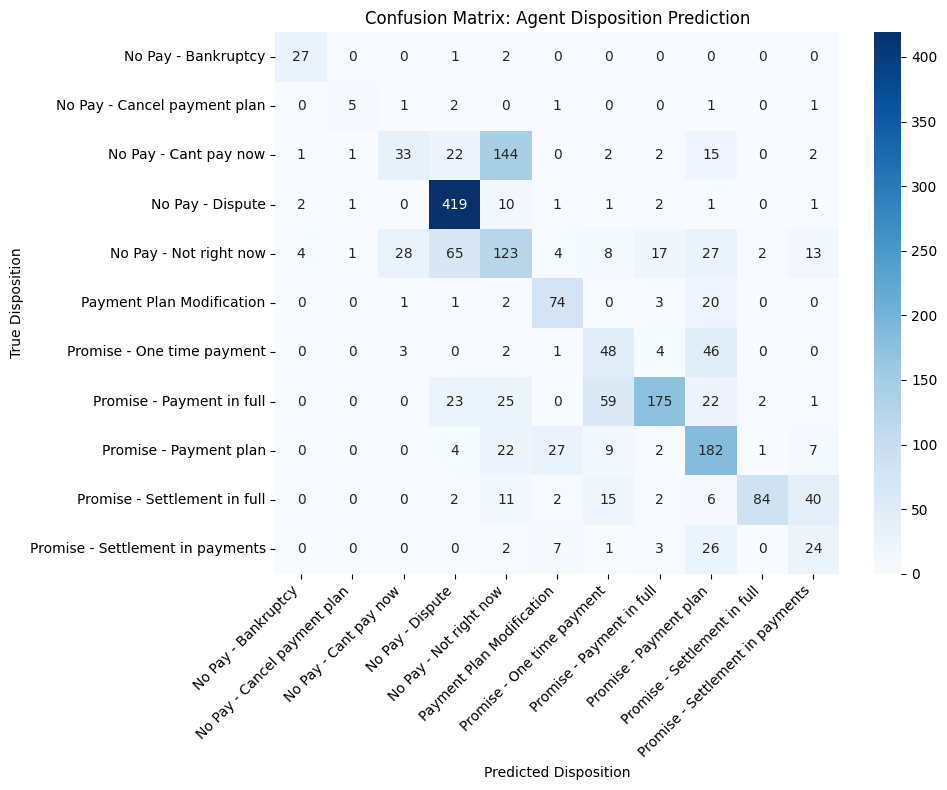

In [53]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

# Ensure both columns are strings for comparison
y_true_agent = merged_df['disposition'].astype(str)
y_pred_agent = merged_df['agent_score'].astype(str)

# Compute metrics
acc_agent = accuracy_score(y_true_agent, y_pred_agent)
prec_agent = precision_score(y_true_agent, y_pred_agent, average='weighted', zero_division=0)
rec_agent = recall_score(y_true_agent, y_pred_agent, average='weighted', zero_division=0)
f1_agent = f1_score(y_true_agent, y_pred_agent, average='weighted', zero_division=0)

print(f"Agent Disposition Prediction Stats:")
print(f"Accuracy: {acc_agent:.4f}")
print(f"Precision (weighted): {prec_agent:.4f}")
print(f"Recall (weighted): {rec_agent:.4f}")
print(f"F1 Score (weighted): {f1_agent:.4f}")
print("\nClassification Report:")
print(classification_report(y_true_agent, y_pred_agent, zero_division=0))

# Confusion matrix
cm_agent = confusion_matrix(y_true_agent, y_pred_agent, labels=sorted(y_true_agent.unique()))
plt.figure(figsize=(10, 8))
sns.heatmap(cm_agent, annot=True, fmt='d', cmap='Blues',
            xticklabels=sorted(y_true_agent.unique()),
            yticklabels=sorted(y_true_agent.unique()))
plt.xlabel('Predicted Disposition')
plt.ylabel('True Disposition')
plt.title('Confusion Matrix: Agent Disposition Prediction')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

## Borrower Score Analysis

In [42]:
# Calculate correlation coefficients between ground_truth_sentiment and borrower_score
corr_borrower = merged_df['ground_truth_sentiment'].corr(merged_df['borrower_score'])

print(f"Correlation (ground_truth_sentiment, borrower_score): {corr_borrower:.4f}")

Correlation (ground_truth_sentiment, borrower_score): 0.6902


         borrower_score                                                 
                  count      mean       std   min   25%  50%   75%   max
type                                                                    
negative          993.0  0.484260  0.177312  0.05  0.35  0.5  0.60  0.95
positive          991.0  0.778577  0.127315  0.20  0.70  0.8  0.85  1.00


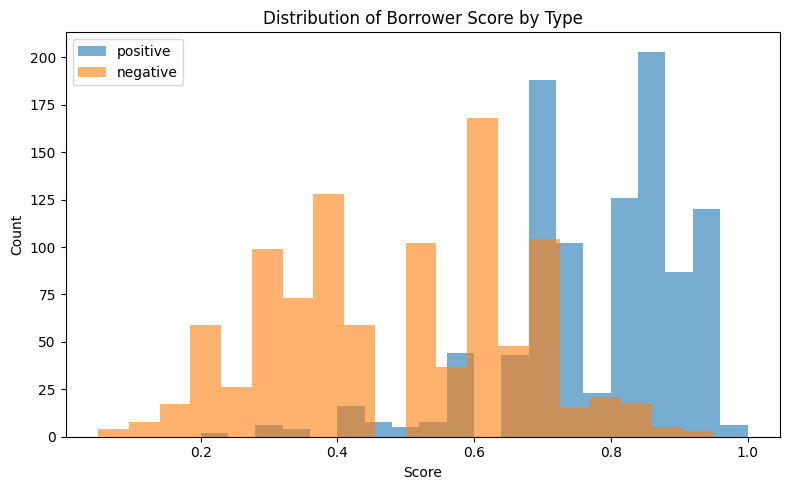

<Figure size 1000x500 with 0 Axes>

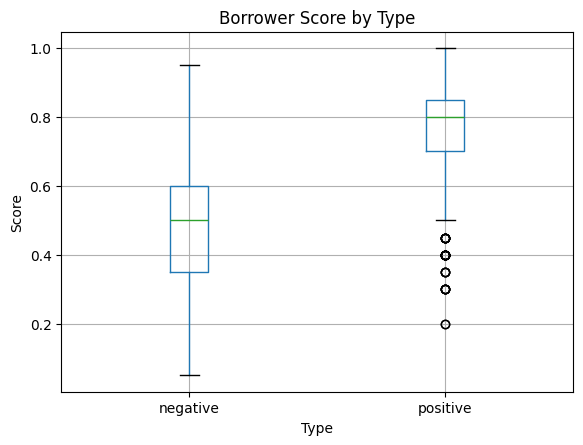

In [50]:
# Group by 'type' and describe agent_score and borrower_score
stats = merged_df.groupby('type')[['borrower_score']].describe()
print(stats)

# Plot distributions
# Single histogram plot for borrower_score by type
plt.figure(figsize=(8, 5))
for sentiment_type in ['positive', 'negative']:
    subset = merged_df[merged_df['type'] == sentiment_type]['borrower_score']
    plt.hist(subset, bins=20, alpha=0.6, label=sentiment_type)
plt.title('Distribution of Borrower Score by Type')
plt.xlabel('Score')
plt.ylabel('Count')
plt.legend()
plt.tight_layout()
plt.show()

# Boxplots for visual comparison
plt.figure(figsize=(10, 5))
merged_df.boxplot(column=['borrower_score'], by='type')
plt.suptitle('')
plt.title('Borrower Score by Type')
plt.xlabel('Type')
plt.ylabel('Score')
plt.show()


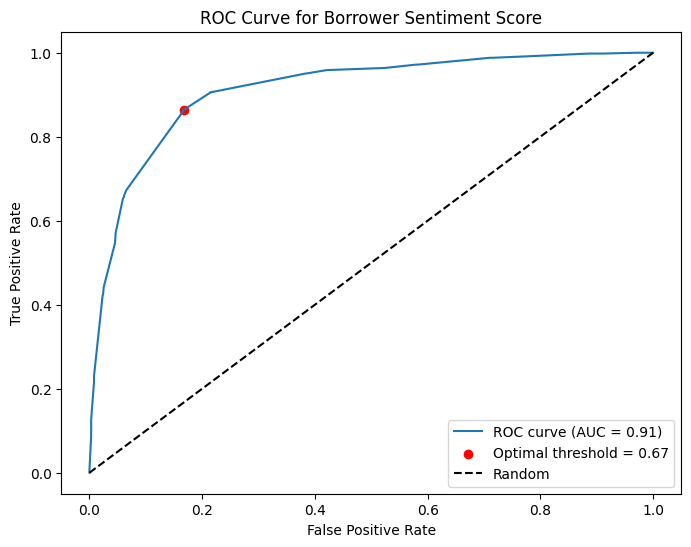

Optimal threshold: 0.67
ROC-AUC: 0.91


In [51]:
from sklearn.metrics import roc_curve, roc_auc_score

# Prepare true labels and predicted scores from merged_df
y_true = merged_df['ground_truth_sentiment']
y_scores = merged_df['borrower_score']

# Compute ROC curve and ROC-AUC
fpr, tpr, thresholds = roc_curve(y_true, y_scores)
roc_auc = roc_auc_score(y_true, y_scores)

# Find optimal threshold (maximizing TPR - FPR)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.scatter(fpr[optimal_idx], tpr[optimal_idx], color='red', label=f'Optimal threshold = {optimal_threshold:.2f}')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Borrower Sentiment Score')
plt.legend()
plt.show()

print(f"Optimal threshold: {optimal_threshold:.2f}")
print(f"ROC-AUC: {roc_auc:.2f}")

Optimal threshold: 0.67
Accuracy: 0.8483
Precision: 0.8369
Recall: 0.8648
F1 Score: 0.8506
Confusion Matrix:


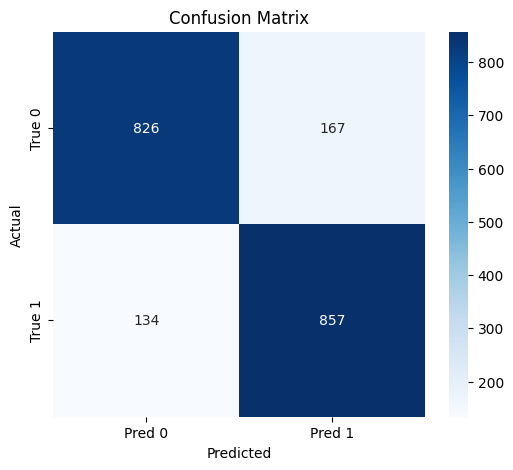

In [52]:
from sklearn.metrics import confusion_matrix

# Use optimal_threshold from previous ROC analysis
pred_optimal = (merged_df['borrower_score'] >= optimal_threshold).astype(int)
true_labels = merged_df['ground_truth_sentiment']

acc = accuracy_score(true_labels, pred_optimal)
prec = precision_score(true_labels, pred_optimal, zero_division=0)
rec = recall_score(true_labels, pred_optimal, zero_division=0)
f1 = f1_score(true_labels, pred_optimal, zero_division=0)
cm = confusion_matrix(true_labels, pred_optimal)

print(f"Optimal threshold: {optimal_threshold:.2f}")
print(f"Accuracy: {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print(f"F1 Score: {f1:.4f}")
print("Confusion Matrix:")
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Pred 0', 'Pred 1'], yticklabels=['True 0', 'True 1'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()